In [39]:
import os, sys, math, datetime
#import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from dotenv import load_dotenv
import boto3
import wandb
from wandb.keras import WandbCallback
import mlflow
import deeplake


In [50]:
models_dir = Path.cwd().joinpath("models")
if not models_dir.exists():
    print(f"{models_dir} does not exist.")
    models_dir.mkdir()
    print(f"Created path: {models_dir}.")


i:\tinyml\tiny_cnn\models does not exist.
Created path: i:\tinyml\tiny_cnn\models.
i:\tinyml\tiny_cnn\models\mobilenet_0.25_96\mobilenet_0.25_96.txt


In [4]:
input_shape =(96,96,3)
classes = 2
alpha = 0.25

In [5]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(
    input_shape=input_shape,
    alpha=alpha,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights=None, #'imagenet'
    input_tensor=None,
    pooling=None,
    classes=classes,
    classifier_activation='softmax',
    #**kwargs
)

In [6]:
mobilenet

In [24]:
model = mobilenet
model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [10]:
summary = model.summary(expand_nested=True)

Model: "mobilenet_0.25_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 8)         216       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 8)        72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 8)        32        
 ation)                                          

In [15]:
summary.__dir__()

['__new__',
 '__repr__',
 '__bool__',
 '__doc__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__init__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

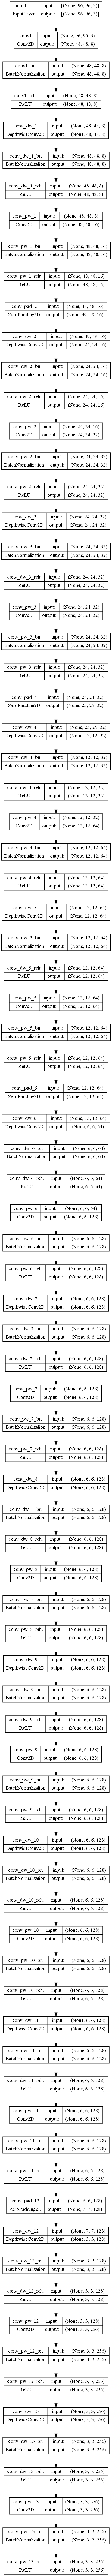

In [18]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [19]:
my_json = model.to_json()

In [20]:
my_json

'{"class_name": "Functional", "config": {"name": "mobilenet_0.25_96", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 96, 96, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv1", "trainable": true, "dtype": "float32", "filters": 8, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv1", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "conv1_bn", "trainable": true, "dtype": "float32"

In [22]:
# from tensorflow.keras.models import Model
# def  Mymodel(backbone_model, classes):
#     backbone = backbone_model
#     x = backbone.output
#     x = tf.keras.layers.Dense(classes,activation='sigmoid')(x)
#     model = Model(inputs=backbone.input, outputs=x)
#     return model

# input_shape = (224, 224, 3)
# model = Mymodel(backbone_model=tf.keras.applications.MobileNet(input_shape=input_shape, include_top=False, pooling='avg'),
#                 classes=61)

# model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [29]:
model_name = model.name
print(model_name)

mobilenet_0.25_96


In [ ]:

models_path = models_dir.joinpath(model_name)
models_summary_path = models_dir.joinpath(model_name, f"{model_name}.txt")
print(models_summary_path)

not existing


In [45]:
from contextlib import redirect_stdout

with open(models_summary_path, 'w') as f:
    with redirect_stdout(f):
        model.summary()

FileNotFoundError: [Errno 2] No such file or directory: 'i:\\tinyml\\tiny_cnn\\models\\mobilenet_0.25_96\\mobilenet_0.25_96.txt'

In [38]:
for layer in model.layers:
    print(layer.name, layer.compute_dtype ,len(layer.variables) , layer.input_shape, layer.output_shape)

input_1 float32 0 [(None, 96, 96, 3)] [(None, 96, 96, 3)]
conv1 float32 1 (None, 96, 96, 3) (None, 48, 48, 8)
conv1_bn float32 4 (None, 48, 48, 8) (None, 48, 48, 8)
conv1_relu float32 0 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1 float32 1 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1_bn float32 4 (None, 48, 48, 8) (None, 48, 48, 8)
conv_dw_1_relu float32 0 (None, 48, 48, 8) (None, 48, 48, 8)
conv_pw_1 float32 1 (None, 48, 48, 8) (None, 48, 48, 16)
conv_pw_1_bn float32 4 (None, 48, 48, 16) (None, 48, 48, 16)
conv_pw_1_relu float32 0 (None, 48, 48, 16) (None, 48, 48, 16)
conv_pad_2 float32 0 (None, 48, 48, 16) (None, 49, 49, 16)
conv_dw_2 float32 1 (None, 49, 49, 16) (None, 24, 24, 16)
conv_dw_2_bn float32 4 (None, 24, 24, 16) (None, 24, 24, 16)
conv_dw_2_relu float32 0 (None, 24, 24, 16) (None, 24, 24, 16)
conv_pw_2 float32 1 (None, 24, 24, 16) (None, 24, 24, 32)
conv_pw_2_bn float32 4 (None, 24, 24, 32) (None, 24, 24, 32)
conv_pw_2_relu float32 0 (None, 24, 24, 32) (None, 24, 24, 32